In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.signal as signal
from scipy import cluster
from Bio import SeqIO
%matplotlib inline

sns.set_style('white')
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

In [3]:
#functions for reading a fasta and calculating the AT content
def loading_fasta_gbk(file_name,typeoffile):
    """reads either fasta or gbk files, file type needs to be given as 'fasta' or 'genbank' """
    loaded=SeqIO.read(file_name, typeoffile)
    return loaded

class Genome:
    def __init__(self, genome_list,genome_annotation, start, end, strand, length):
        self.name=genome_list #list with every gene name such as CCNA_00001
        self.annotation=genome_annotation # gene annotation if there is one, if none stores NA
        self.start=start # stores translational start position for each gene
        self.end=end #stores end position of each gene
        self.strand=strand # + or - strand (+1 or -1)
        self.length=length # length of gene

def reading_gbk_new(gbk_file, features_to_extract):
    """function that will load from the gbk file: the start, end, strand and length of gene as well as the name and annotated name/function. 
    Returns one array and 2 lists """
    
    genome_gene=[]
    genome_gene_name=[]
    
    genome_start=[]
    genome_end=[]
    genome_strand=[]
    genome_length=[]
    print(len(features_to_extract))
    for i in range(0,len(gbk_file.features)):
        isfeature=False
        for j in range(len(features_to_extract)):
            if gbk_file.features[i].type == features_to_extract[j]:
                isfeature=True
            
        if isfeature==True:
            
            genome_gene.append(gbk_file.features[i].qualifiers['locus_tag'][0])

            if 'product' in gbk_file.features[i].qualifiers:
                genome_gene_name.append(gbk_file.features[i].qualifiers['product'][0]) 
            else:
                genome_gene_name.append('NA')

            if gbk_file.features[i].location.strand < 0 :
                genome_start.append(gbk_file.features[i].location.end)
                genome_end.append(gbk_file.features[i].location.start)
                genome_strand.append(-1)
                genome_length.append(abs(gbk_file.features[i].location.end-gbk_file.features[i].location.start)+1)
            else:
                genome_start.append(gbk_file.features[i].location.start)
                genome_end.append(gbk_file.features[i].location.end)
                genome_strand.append(1)
                genome_length.append(abs(gbk_file.features[i].location.end-gbk_file.features[i].location.start)+1)

    genome = Genome(genome_gene,genome_gene_name,genome_start,genome_end,genome_strand,genome_length) 
    
    return genome    

def readGenome(a, skip = 0):
    genomeFile = open(a, 'r')
    out = ''
    if skip != 0:
        for i in range(0,skip,1):
                genomeFile.readline()
    line = genomeFile.readline()
    while line != '':
        out = out + line[:-1]
        line = genomeFile.readline()
    return out

def readCDSMG1655(annoteFile, skip = 0):
    a = open(annoteFile, 'r')
    gtype, start, end, strand, funct, bNum, gene = [], [], [], [], [], [], []
    for i in range(0,skip):
        a.readline()
    line = a.readline()
    while line != '':
        if regex.findall('CDS', line):
            z = line.split('\t')
            b = z[8].split('ID=')
            c = b[1].split(':')[0]
            gtype.append(z[2])
            start.append(z[3])
            end.append(z[4])
            strand.append(z[6])
            if regex.findall('product', line):
                zz = line.split('product=')[1]
                funct.append(zz.split(';')[0])
            else:
                funct.append('n/a')
            y = line.split('locus_tag=')[1]
            bNum.append(y.split(';')[0])
            gene.append(c.split('\"')[0])
        line = a.readline()
    out = np.array([gtype, start, end, strand, funct, bNum, gene])
    out = pd.DataFrame(out).transpose()
    out.columns = ['gtype', 'start', 'end', 'strand', 'function', 'bNum', 'geneName']
    return out

In [4]:
genome_folder = '../genomes/'
ecolifasta=loading_fasta_gbk(genome_folder + 'NC000913_2.fasta','fasta')
ecoligbk=loading_fasta_gbk(genome_folder + 'NC_000913_2.gbk','genbank')
genome=reading_gbk_new(ecoligbk,['CDS','tRNA','rRNA','ncRNA'])

4


In [5]:
#Generate genome reference and operon reference
MG1655 = readGenome('../genomes/NC000913_2.fasta', 1)
MG1655annoteFile = '../genomes/gffEditedNoDup.txt'
annote = readCDSMG1655(MG1655annoteFile, 3)

ecolifasta=loading_fasta_gbk('../genomes/NC000913_2.fasta','fasta')
ecoligbk=loading_fasta_gbk('../genomes/NC_000913_2.gbk','genbank')
genome=reading_gbk_new(ecoligbk,['CDS','tRNA','rRNA','ncRNA'])

MGoperons = pd.read_csv('./norm_coli_data/MGoperons_D19-11576-4278G_with_rpkM.csv', sep = ',', index_col = 0)

4


In [6]:
def loadChipData():
    chip = pd.DataFrame()
    for i in [2,5,6,9]:
        chip[i] = pd.read_csv('./norm_coli_data/D18-1147{}-3531L_norm.wig'.format(i), sep = '\t', header = None, skiprows=2)[1]
    chip.columns = ['neg','high','Rif_neg','Rif_high']
    chip['wt0'] = pd.read_csv('./norm_coli_data/D19-5503-3883G_norm.wig', sep = '\t', header = None, skiprows=2)[1]
    chip['wtH'] = pd.read_csv('./norm_coli_data/D19-5504-3883G_norm.wig', sep = '\t', header = None, skiprows=2)[1]

    return chip

chip = loadChipData()

In [7]:
chip['neg_rep2'] = pd.read_csv('./norm_coli_data/D19-11568-4278G_MG1655_norm.wig', sep = '\t', header = None, skiprows=2)[1]
chip['high_rep2'] = pd.read_csv('./norm_coli_data/D19-11570-4278G_MG1655_norm.wig', sep = '\t', header = None, skiprows=2)[1]
chip['wt0_rep2'] = pd.read_csv('./norm_coli_data/D19-11571-4278G_MG1655_norm.wig', sep = '\t', header = None, skiprows=2)[1]
chip['wtH_rep2'] = pd.read_csv('./norm_coli_data/D19-11573-4278G_MG1655_norm.wig', sep = '\t', header = None, skiprows=2)[1]

In [9]:
#import RNA-seq wigs
RNAseqf_me = pd.read_csv('./norm_coli_data/D19-11576-4278G_MG1655_norm_fw.wig',sep = '\t',header = None,skiprows=2, index_col=0)
RNAseqr_me = pd.read_csv('./norm_coli_data/D19-11576-4278G_MG1655_norm_rv.wig',sep = '\t',header = None,skiprows=2, index_col=0)
RNAseq_me = RNAseqf_me.reindex(RNAseqf.index,fill_value=0)
RNAseq_me['rev'] = RNAseqr_me.reindex(RNAseqf.index,fill_value=0)
RNAseq_me.columns = ['fwd','rev']

In [10]:
##Genome representation
#puts a 1 where there is a gene

genome_gene_representation = np.zeros([1,len(ecolifasta.seq)])

for genes in [genome]:
    for i in range (0, len(genes.annotation)):
        if genes.strand[i]== +1:
            
            for j in range(0, genes.length[i]-1):
                genome_gene_representation[0][genes.start[i]+j]=10
        else:
            for j in range(0,genes.length[i]-1):
                genome_gene_representation[0][genes.end[i]+j]=-10
                
##calculating ATcontent
def ATcontent(start, end):
    from Bio.Seq import Seq, MutableSeq 
    from Bio.SeqUtils import GC  
    content=100-(GC(ecolifasta.seq[start:end]))
    return content

### code a sliding window to record AT content
def sliding_window(window_length):
    sliding_array=np.zeros([1,len(ecolifasta.seq)])
    for i in range(int(window_length/2), len(ecolifasta.seq)-int(window_length/2)):
        start=i-int(window_length/2)
        end=i+int(window_length/2)
        sliding_array[0][i]=ATcontent(start, end)
    return sliding_array

sliding_100=sliding_window(100)

### Fig. 3B

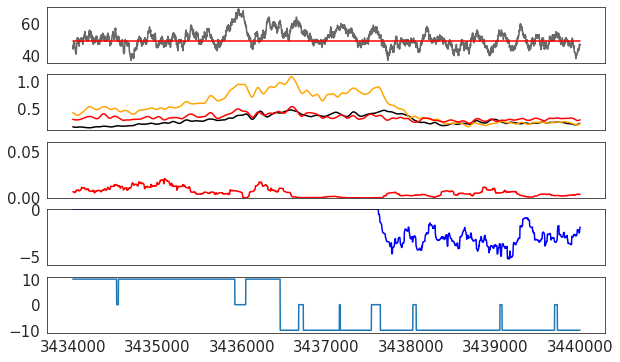

In [14]:
#Fig 3B, rib protein operon
start = 3434000
end = 3440000
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),sliding_100[0][start:end],'dimgrey')
axes[0].plot([start, end],[np.mean(sliding_100[0]),np.mean(sliding_100[0])],'red')
axes[1].plot(np.arange(start, end),chip.wtH[start:end],'black')
axes[1].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[1].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[2].plot(np.arange(start, end),(RNAseq_me['fwd'][start:end]),'red')
axes[3].plot(np.arange(start, end),-(RNAseq_me['rev'][start:end]),'blue')

axes[2].set_ylim(0, 0.06)
axes[3].set_ylim(-6, 0)

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)

axes[4].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig. 3C

In [73]:
#Uses only one operon in convergent / divergent orientation to prevent double counting
operonLen = 1500
N = 1000
plus = MGoperons[(MGoperons.strand == 0) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]
minus = MGoperons[(MGoperons.strand == 1) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.start >= values.end) & (minus.start <= values.end+1000)])
    if len(x) != 0:
        t.append(x)

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.start) & (plus.start <= values.end+1000)])
    if len(x) != 0:
        t2.append(x)

minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
plus_new = plus.copy()
for x in t2:
    plus_new.drop(index = x.index,inplace=True)

t-test of end of TUs: 3.284 Ttest_indResult(statistic=7.548116052705982, pvalue=1.203739258356844e-13)
t-test of end of TUs: 25.7 Ttest_indResult(statistic=9.655877865149824, pvalue=2.4622253271351495e-20)
t-test of end of TUs: 65 Ttest_indResult(statistic=10.458820914985315, pvalue=1.2722589864731118e-22)


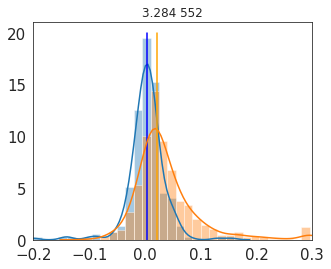

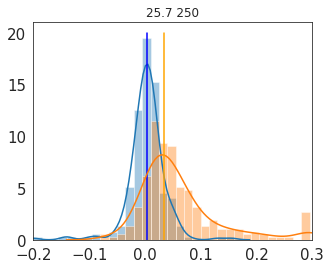

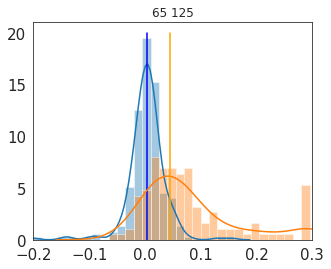

In [74]:
#different transcriptional cutoffs, 3pr end
#figure titles indicate rpkm cutoff and number of TUs
operonLen = 1500
N = 1000
thrsh_x_2 = 3.284

rand_prob_3pr = {}
for thrsh_x in [3.284,25.7,65]:
    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in plus[1:].iterrows():
        if values.newRPK > thrsh_x:
            end = int(values.end)
            if end < len(MG1655)-N:
                data_y_end.append((np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N))
                
        elif values.newRPK < thrsh_x_2:
            end = int(values.end)
            if end < len(MG1655)-N:
                data_y2_end.append((np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N))
    data_y_plus_end=data_y_end
    data_y_plus_end_2=data_y2_end
    data_y_plus_start=data_y_start
    data_y_plus_start_2=data_y2_start


    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in minus_new.iterrows():
        if values.newRPK > thrsh_x:
            end = int(values.start)
            if end > N:
                data_y_end.append((np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N))
                
        elif values.newRPK < thrsh_x_2:
            end = int(values.start)
            if end > N:
                data_y2_end.append((np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N))
                
    data_y_rev_end=data_y_end
    data_y_rev_end_2=data_y2_end
    data_y_rev_start=data_y_start
    data_y_rev_start_2=data_y2_start

    data_y_concat_end=np.concatenate((data_y_plus_end,data_y_rev_end))
    data_y_concat_2_end=np.concatenate((data_y_plus_end_2,data_y_rev_end_2))
    data_y_concat_start=np.concatenate((data_y_plus_start,data_y_rev_start))
    data_y_concat_2_start=np.concatenate((data_y_plus_start_2,data_y_rev_start_2))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_2_end,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_2_end)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
    
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_end,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_end)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
    
    plt.xlim([-0.2,0.3])

    axes.set_title(str(thrsh_x)+' '+str(len(data_y_concat_end)))

    print('t-test of end of TUs: '+ str(thrsh_x) + ' '+ str(stats.ttest_ind(data_y_concat_end,data_y_concat_2_end)))

t-test of end of TUs: 3.284 Ttest_indResult(statistic=-0.19407411928839707, pvalue=0.8461679916942154)
t-test of end of TUs: 25.7 Ttest_indResult(statistic=0.41957582896196516, pvalue=0.6749766514168105)
t-test of end of TUs: 65 Ttest_indResult(statistic=2.0917185678569137, pvalue=0.037146842259537786)


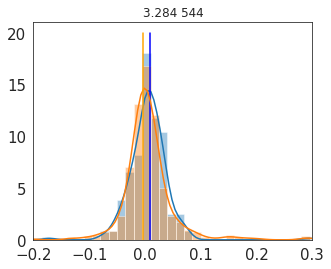

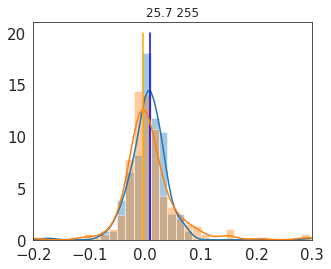

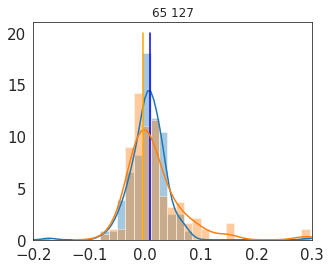

In [76]:
#different transcriptional cutoffs, 5pr end
#figure titles indicate rpkm cutoff and number of TUs
operonLen = 1500
N = 1000
thrsh_x_2 = 3.284

rand_prob_3pr = {}
for thrsh_x in [3.284,25.7,65]:
    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in plus_new.iterrows():
        if values.newRPK > thrsh_x:
            start = int(values.start)
            if start > N:
                data_y_start.append((np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N))
        elif values.newRPK < thrsh_x_2:
            start = int(values.start)
            if start > N:
                data_y2_start.append((np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N))
    data_y_plus_end=data_y_end
    data_y_plus_end_2=data_y2_end
    data_y_plus_start=data_y_start
    data_y_plus_start_2=data_y2_start


    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in minus.iterrows():
        if values.newRPK > thrsh_x:
            start = int(values.end)
            if start < len(MG1655)-N:
                data_y_start.append((np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N))
        elif values.newRPK < thrsh_x_2:
            start = int(values.end)
            if start < len(MG1655)-N:
                data_y2_start.append((np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N))
                
    data_y_rev_end=data_y_end
    data_y_rev_end_2=data_y2_end
    data_y_rev_start=data_y_start
    data_y_rev_start_2=data_y2_start

    data_y_concat_end=np.concatenate((data_y_plus_end,data_y_rev_end))
    data_y_concat_2_end=np.concatenate((data_y_plus_end_2,data_y_rev_end_2))
    data_y_concat_start=np.concatenate((data_y_plus_start,data_y_rev_start))
    data_y_concat_2_start=np.concatenate((data_y_plus_start_2,data_y_rev_start_2))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_2_start,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_2_start)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
    
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_start,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_start)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
    
    plt.xlim([-0.2,0.3])

    axes.set_title(str(thrsh_x)+' '+str(len(data_y_concat_start)))

    print('t-test of end of TUs: '+ str(thrsh_x) + ' '+ str(stats.ttest_ind(data_y_concat_start,data_y_concat_2_start)))

### Fig. 3D

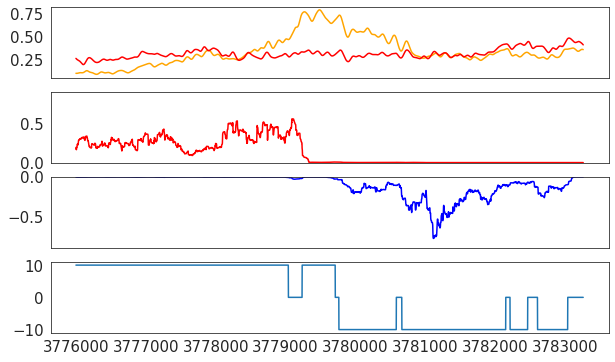

In [17]:
start=3776000
end=3783261
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[1].plot(np.arange(start, end),(RNAseq_me['fwd'][start:end]),'red')
axes[2].plot(np.arange(start, end),-(RNAseq_me['rev'][start:end]),'blue')
axes[1].set_ylim([0,0.9])
axes[2].set_ylim([-0.9,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])

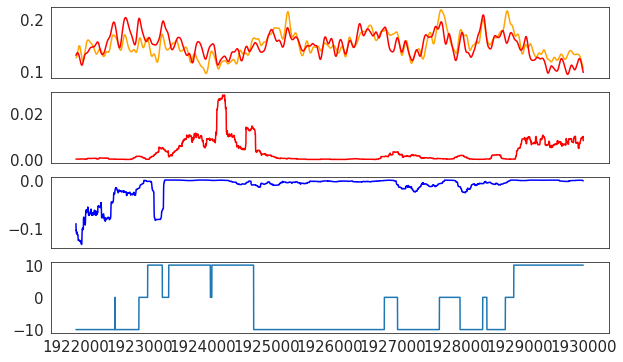

In [18]:
start=1922000
end=1930000
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[1].plot(np.arange(start, end),(RNAseq_me['fwd'][start:end]),'red')
axes[2].plot(np.arange(start, end),-(RNAseq_me['rev'][start:end]),'blue')

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig. 3E

/home/msguo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/msguo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


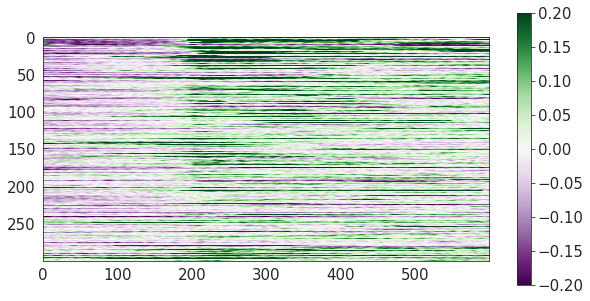

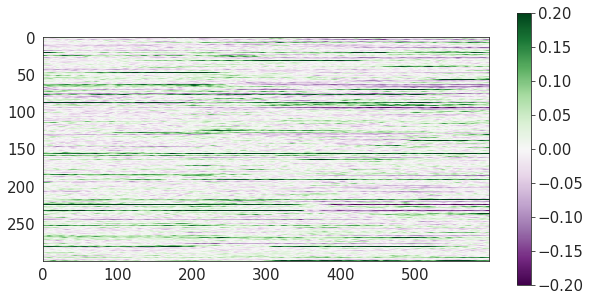

In [20]:
#heatmaps for 5pr/3pr GapR enrichment based on transcriptional level, this is the 3pr end
MGoperons = pd.read_csv('./norm_coli_data/MGoperons_D19-11576-4278G_with_rpkM.csv', sep = ',', index_col = 0)
chip_diff = chip.high-chip.Rif_high

GapEnrich = []
rpkM = []
ind = []
for i, j in MGoperons[1:-2].iterrows():
    if j.end-j.start >=1500:
        if j.newRPK >= 0:
            rpkM.append(j.newRPK)
            ind.append(i)
            if j.strand == 0:
                GapEnrich.append(chip_diff[j.end-2000:j.end+4000].values)
            else:
                GapEnrich.append(chip_diff[j.start-4000:j.start+2000].values[::-1])

binSize = 10
out = []
for j in range(len(GapEnrich)):
    a = []
    for i in range(0,6000,binSize):
        a.append(np.mean(GapEnrich[j][i:i+10]))
    out.append(a)
    
newMat = pd.DataFrame([rpkM,out],['rpkM','thrends']).transpose()
newMat.sort_values('rpkM',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.thrends)
    
#high expression heatmap
plt.figure(figsize = [10,5])
plt.imshow(sortedGapEnrich[0:300],vmin=-0.20,vmax=0.20,cmap='PRGn')
plt.colorbar()

#low expression heatmap
plt.figure(figsize = [10,5])
plt.imshow(sortedGapEnrich[-300:],vmin=-0.20,vmax=0.20,cmap='PRGn')
plt.colorbar()

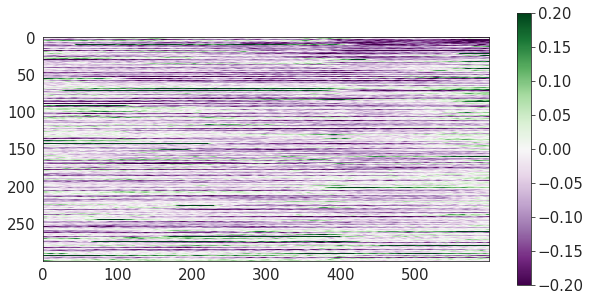

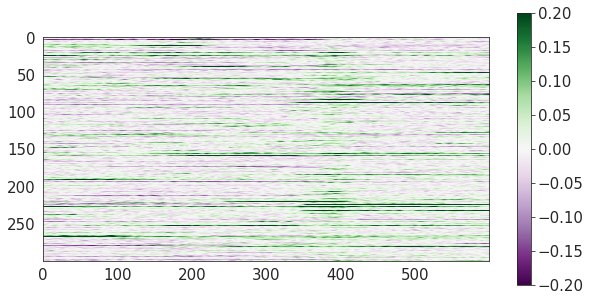

In [21]:
#heatmaps for 5pr/3pr GapR enrichment based on transcriptional level, this is the 5pr end
GapEnrich = []
rpkM = []
ind = []
for i, j in MGoperons[1:-2].iterrows():
    if j.end-j.start >=1500:
        if j.newRPK >= 0:
            rpkM.append(j.newRPK)
            ind.append(i)
            if j.strand == 0:
                GapEnrich.append(chip_diff[j.start-4000:j.start+2000].values)
            else:
                GapEnrich.append(chip_diff[j.end-2000:j.end+4000].values[::-1])
            
binSize = 10

out = []
for j in range(len(GapEnrich)):
    a = []
    for i in range(0,6000,binSize):
        a.append(np.mean(GapEnrich[j][i:i+10]))
    out.append(a)
    
newMat = pd.DataFrame([rpkM,out],['rpkM','thrends']).transpose()
newMat.sort_values('rpkM',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.thrends)
    
#high expression heatmap
plt.figure(figsize = [10,5])
plt.imshow(sortedGapEnrich[0:300],vmin=-0.20,vmax=0.20,cmap='PRGn')
plt.colorbar()

#low expression heatmap
plt.figure(figsize = [10,5])
plt.imshow(sortedGapEnrich[-300:],vmin=-0.20,vmax=0.20,cmap='PRGn')
plt.colorbar()

### Fig. S3A

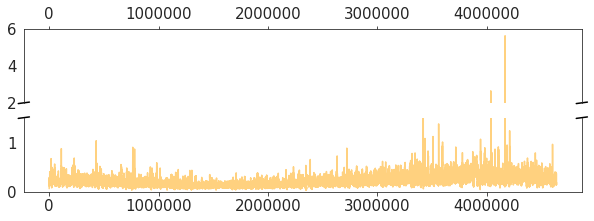

In [22]:
#Fig. S3A_1 GapR-3xFLAG ChIP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,3),sharex=True)
startplot=1
endplot=len(chip.high)
axes[0].plot(np.arange(startplot, endplot,25), chip.high[startplot:endplot:25], 'orange',alpha = 0.5)
axes[1].plot(np.arange(startplot, endplot,25), chip.high[startplot:endplot:25], 'orange',alpha = 0.5)

# zoom-in / limit the view to different portions of the data
axes[0].set_ylim(2.0, 6)  # outliers only
axes[1].set_ylim(0, 1.5)  # most of the data

# hide the spines between ax and ax2
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop='off')  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()
#fig.subplots_adjust(hspace=0.1)

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axes[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


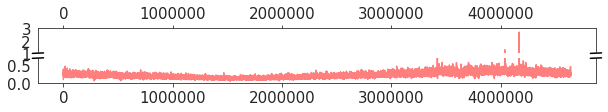

In [23]:
#Fig. S3A_2 GapR-3xFLAG ChIP + rif
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,1),sharex=True)
startplot=1
endplot=len(chip.high)
axes[0].plot(np.arange(startplot, endplot,25), chip.Rif_high[startplot:endplot:25], 'red',alpha = 0.5)
axes[1].plot(np.arange(startplot, endplot,25), chip.Rif_high[startplot:endplot:25], 'red',alpha = 0.5)
# zoom-in / limit the view to different portions of the data
axes[0].set_ylim(1, 3)  # outliers only
axes[1].set_ylim(0, 0.7)  # most of the data

# hide the spines between ax and ax2
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop='off')  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()
#fig.subplots_adjust(hspace=0.1)

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axes[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

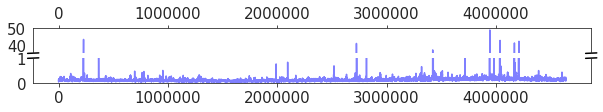

In [29]:
#Fig. S3A_3 GapR ChIP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,1),sharex=True)
startplot=1
endplot=len(chip.high)
axes[0].plot(np.arange(startplot, endplot,25), chip.wtH[startplot:endplot:25], 'blue', alpha=0.5)
axes[1].plot(np.arange(startplot, endplot,25), chip.wtH[startplot:endplot:25], 'blue', alpha=0.5)

# zoom-in / limit the view to different portions of the data
axes[1].set_ylim(0,1)  # outliers only
axes[0].set_ylim(35, 50)  # most of the data

# hide the spines between ax and ax2
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop='off')  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axes[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

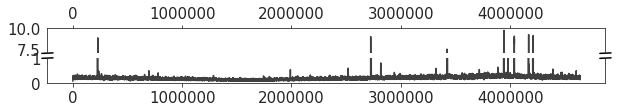

In [28]:
#Fig. S3A_4 GapR-3xFLAG no aTc ChIP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,1),sharex=True)
startplot=1
endplot=len(chip.high)
axes[0].plot(np.arange(startplot, endplot,25), chip.neg[startplot:endplot:25], 'k', alpha = 0.75)
axes[1].plot(np.arange(startplot, endplot,25), chip.neg[startplot:endplot:25], 'k', alpha = 0.75)

# zoom-in / limit the view to different portions of the data
axes[1].set_ylim(0,1)  # outliers only
axes[0].set_ylim(7, 10)  # most of the data

# hide the spines between ax and ax2
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop='off')  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axes[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

### Fig. S3C

In [30]:
#improve aesthetics -- exclude rrna operons

#mask rRNA loci
def maskrRNA(chipFile):
    chipFile[4034004:4038929] = np.nan
    chipFile[4166428:4170080] = np.nan
    chipFile[3939350:3945307] = np.nan
    chipFile[3421216:3427258] = np.nan
    chipFile[4203834:4221970] = np.nan
    chipFile[2723768:2729041] = np.nan
    chipFile[223408:229167] = np.nan
    return chipFile

#Mask rRNA loci where it's probably false-positive ChIP
chip_high_mask = maskrRNA(chip.high.astype(float))
chip_high2_mask = maskrRNA(chip.high_rep2.astype(float))
chip_wtH_mask = maskrRNA(chip.wtH.astype(float))
chip_wtH2_mask = maskrRNA(chip.wtH_rep2.astype(float))

In [32]:
RNA_G3xFneg = pd.read_csv('./norm_coli_data/D19-11574-4278G_means', sep = '\t')
RNA_G3xFH = pd.read_csv('./norm_coli_data/D19-11576-4278G_means', sep = '\t')

(0.9796527752821199, 0.0)


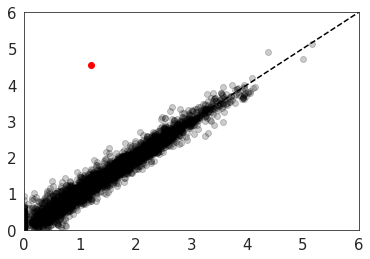

In [33]:
#correlation between gene expression +/- aTc in GapR-3xFLAG strain. Red dot indicates gapR-3xFLAG transcript
plt.plot(np.log10(RNA_G3xFneg.rpkM[:-1]+1), np.log10(RNA_G3xFH.rpkM[:-1]+1),'o',color='k',alpha=0.2)
plt.scatter(np.log10(RNA_G3xFneg[RNA_G3xFneg.geneName == 'gapR'].rpkM.values), np.log10(RNA_G3xFH[RNA_G3xFH.geneName == 'gapR'].rpkM.values),color='red')
plt.plot([0,6],[0,6],'--',color = 'k')
plt.xlim([0,6])
plt.ylim([0,6])
print(stats.pearsonr(np.log10(RNA_G3xFneg.rpkM[:-1]+1), np.log10(RNA_G3xFH.rpkM[:-1]+1)))

### Fig. S3D

In [34]:
#from peter et al 2004 (cozzarelli), top 10% of genes of each class:
relax_repressed = ['yraM','dapA','yraN','pgi','ribF','ileS','yhaJ','crl','pepA','yihE','yadF','yfgA','mukF','ydiJ','glmS','gcvR','pnp','cpxA','polA','sbcB']
relax_repressed = ['yraM','dapA','yraN','pgi','ribF','ileS','yhaJ','crl','pepA','rdoA','can','yfgA','mukF','ydiJ','glmS','gcvR','pnp','cpxA','polA','sbcB']

relax_induced = ['mcrB','htrL','b1983','b1170','deoC','mcrC','fixA','b1330','deoA','yleB','rfaI']
relax_induced = ['mcrB','htrL','yeeN','ycgH','deoC','mcrC','fixA','ynaI','deoA','ubiF','rfaI']

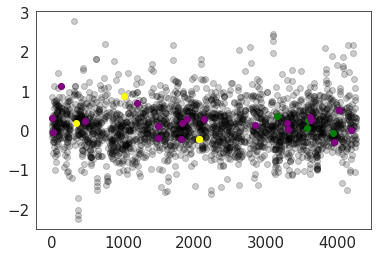

In [35]:
RNA = RNA_G3xFH.copy()
RNA['G3xFneg'] = RNA_G3xFneg.rpkM.copy()
RNA['H/neg'] = np.log2((RNA_G3xFH.rpkM+1)/(RNA_G3xFneg.rpkM+1))

topos = RNA[RNA.geneName.isin(['gyrA','gyrB','parC','parE'])].index.values
cutoff = RNA[(RNA['rpkM']>20) | (RNA['G3xFneg'] > 20)]
fold_ch = cutoff[(cutoff['H/neg'] >=2 ) | (cutoff['H/neg'] <= -2)].index.values

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

plt.plot(cutoff['H/neg'][:-1],'o',color='k',alpha=0.2)
plt.plot(cutoff[cutoff.index.isin(topos)]['H/neg'],'o',color='green')
plt.plot(cutoff[cutoff.geneName.isin(relax_induced)]['H/neg'],'o',color='yellow')
plt.plot(cutoff[cutoff.geneName.isin(relax_repressed)]['H/neg'],'o',color='purple')

### Fig. S3E

In [57]:
#correlation between 2 GapR experiments, excluding the rrna/rdna operons

#mask rRNA loci
def maskrRNA(chipFile):
    chipFile[4034004:4038929] = np.nan
    chipFile[4166428:4170080] = np.nan
    chipFile[3939350:3945307] = np.nan
    chipFile[3421216:3427258] = np.nan
    chipFile[4203834:4221970] = np.nan
    chipFile[2723768:2729041] = np.nan
    chipFile[223408:229167] = np.nan
    return chipFile

#Mask rRNA loci where it's probably false-positive ChIP
chip_high_mask = np.array(maskrRNA(chip.high.astype(float)))
chip_high2_mask = np.array(maskrRNA(chip.high_rep2.astype(float)))
chip_wtH_mask = np.array(maskrRNA(chip.wtH.astype(float)))
chip_wtH2_mask = np.array(maskrRNA(chip.wtH_rep2.astype(float)))

h1 = np.nancumsum(chip_high_mask)
h2 = np.nancumsum(chip_high2_mask)

In [40]:
#bin data
N = 100
avgapR_highrep1 = []
avgapR_highrep2 = []
for x in np.arange(0,len(ecolifasta.seq),N):
    try:
        avgapR_highrep1.append((h1[x+N]-h1[x])/N)
        avgapR_highrep2.append((h2[x+N]-h2[x])/N)
    except:
        avgapR_highrep1.append((h1[len(ecolifasta.seq)-1]-h1[x])/N)
        avgapR_highrep2.append((h2[len(ecolifasta.seq)-1]-h2[x])/N)


(0.9365654221770416, 0.0)


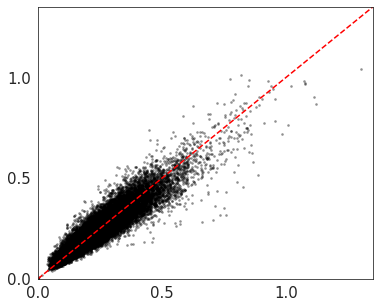

In [41]:
#Generate correlation plot
plt.figure(figsize=(6,5))
plt.scatter(avgapR_highrep1,avgapR_highrep2, marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.plot([0,1.35],[0,1.35],'--',c='red')
plt.xlim([0,1.35])
plt.ylim([0,1.35])
plt.xticks([0,0.5,1.0],size = 15)
plt.yticks([0,0.5,1.0],size = 15)
print(stats.pearsonr(avgapR_highrep1,avgapR_highrep2))

### Fig. S3F

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


(1, 100)

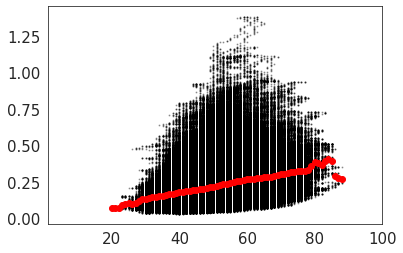

In [46]:
#generate AT content vs e coli genome, masking rRNA loci

##calculating ATcontent
def ATcontent(start, end):
    from Bio.Seq import Seq, MutableSeq 
    from Bio.SeqUtils import GC  
    content=100-(GC(ecolifasta.seq[start:end]))
    return content

### code a sliding window to record AT content
def sliding_window(window_length):
    sliding_array=np.zeros([1,len(ecolifasta.seq)])
    for i in range(int(window_length/2), len(ecolifasta.seq)-int(window_length/2)):
        start=i-int(window_length/2)
        end=i+int(window_length/2)
        sliding_array[0][i]=ATcontent(start, end)
    return sliding_array

sliding_100=sliding_window(100)

#mask rRNA loci
def maskrRNA(chipFile):
    chipFile[4034004:4038929] = np.nan
    chipFile[4166428:4170080] = np.nan
    chipFile[3939350:3945307] = np.nan
    chipFile[3421216:3427258] = np.nan
    chipFile[4203834:4221970] = np.nan
    chipFile[2723768:2729041] = np.nan
    chipFile[223408:229167] = np.nan
    return chipFile

#Mask rRNA loci where it's probably false-positive ChIP
chip_high_mask = maskrRNA(chip.high.astype(float))
chip_wtH_mask = maskrRNA(chip.wtH.astype(float))

avgapR = []
for i in range(10,90):
    avgapR.append(np.nanmean(chip_high_mask[(sliding_100[0]>=i) & (sliding_100[0]<i+1)]))

plt.scatter(sliding_100[0],chip_high_mask, marker = 'o', s = 1, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.scatter(range(10,90),avgapR,c='red',marker = 'o')
plt.xlim([1,100])

In [47]:
#Guo and Haakonsen et al caulo data
def loading_fasta_gbk(file_name,typeoffile):
    """reads either fasta or gbk files, file type needs to be given as 'fasta' or 'genbank' """
    loaded=SeqIO.read(file_name, typeoffile)
    return loaded

caulobactergbk=loading_fasta_gbk('./diane_caulo_data/' + 'NC_011916.gbk','genbank')
caulobacterfasta=loading_fasta_gbk('./diane_caulo_data/' + 'NC_011916.fna','fasta')
#genome=reading_gbk_new(caulobactergbk,['CDS','tRNA','rRNA','ncRNA'])

def gaussian_smooth(data_array, index_step, sigma):
    mu = 0
    bins = np.arange(-4*sigma, 4*sigma, index_step, dtype=np.float32)
    gaussian = index_step*1/(sigma * np.sqrt(2 * np.pi))*np.exp( - (bins - mu)**2 / (2 * sigma**2) )
    return signal.convolve(data_array,gaussian,mode='same')

def initialize_rpm(data,index_step,length):
    
    smoothed_data = np.zeros([1, length], dtype=np.float32)
    smoothed_data[0][:] = gaussian_smooth(data[0],index_step,5*index_step)
    rpm = np.zeros([1, length])
    normalization_factor=float(sum(smoothed_data[0][:]))/float(1000000)
    print(normalization_factor)
    for i in range(0,length):
        rpm[0][i]=float(smoothed_data[0][i])/normalization_factor
        
    return rpm

### function for loading data
def loading_chip_data(name):
    coordinate=np.loadtxt(name, dtype=np.int32, delimiter='\t', skiprows=2)
    chip_data=np.zeros([1,len(caulobacterfasta.seq)])
    ind=coordinate[:,0]<len(caulobacterfasta.seq)
    chip_data[0][coordinate[ind,0]-1]=coordinate[ind,1]
    chip_rpm=initialize_rpm(chip_data, 10, len(caulobacterfasta.seq))
    return chip_rpm

#negative control
chip_neg=loading_chip_data('./diane_caulo_data/160614Lau_D16-5512_CcreNA1000_bestmap.sammacs.samout_treat_afterfiting_gi_221232939_ref_NC_011916.1_.wig')
#GapR-3xFLAG
chip_356=loading_chip_data('./diane_caulo_data/160614Lau_D16-5510_CcreNA1000_bestmap.sammacs.samout_treat_afterfiting_gi_221232939_ref_NC_011916.1_.wig')
#GapR-3xFLAG RFI treated
chip_rif=loading_chip_data('./diane_caulo_data/160614Lau_D16-5513_CcreNA1000_bestmap.sammacs.samout_treat_afterfiting_gi_221232939_ref_NC_011916.1_.wig')

caulo = pd.DataFrame(chip_neg[0])
caulo['356'] = chip_356[0]
caulo.columns = ['wt','gapR']

1999.7841615275802
1999.7386810940875
1999.6622785071706


In [50]:
##calculating ATcontent, caulos
def ATcontent_caulo(start, end):
    from Bio.Seq import Seq, MutableSeq 
    from Bio.SeqUtils import GC  
    content=100-(GC(caulobacterfasta.seq[start:end]))
    return content

### code a sliding window to record AT content
def sliding_window_caulo(window_length):
    sliding_array=np.zeros([1,len(caulobacterfasta.seq)])
    for i in range(int(window_length/2), len(caulobacterfasta.seq)-int(window_length/2)):
        start=i-int(window_length/2)
        end=i+int(window_length/2)
        sliding_array[0][i]=ATcontent_caulo(start, end)
    return sliding_array

sliding_100_caulo=sliding_window_caulo(100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


(1, 100)

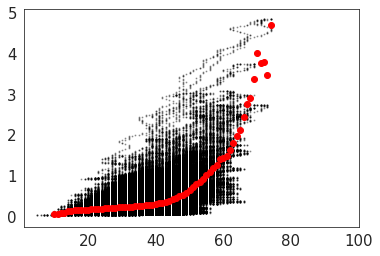

In [55]:
avgapR_caulo = []
for i in range(10,90):
    avgapR_caulo.append(np.nanmean(caulo['gapR'][(sliding_100_caulo[0]>=i) & (sliding_100_caulo[0]<i+1)]))

plt.scatter(sliding_100_caulo[0],caulo['gapR'], marker = 'o', s = 1, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.scatter(range(10,90),avgapR_caulo,c='red',marker = 'o')
plt.xlim([1,100])

In [42]:
#recover 200 bp around most enriched GapR-3xFLAG regions
half_window = 100

def enrichedRegions(chip_data, cutoff):
    x = chip_data[chip_data > cutoff]
    out = []
    z = x.index[0]
    start = x.index[0]
    for i in range(1,len(x.index)):
        if x.index[i] == z+1:
            z = x.index[i]
        else:
            end = z
            out.append([start,end])
            z = x.index[i]
            start = x.index[i]
    out.append([start,z])
    return out 

def getSequence(chipRegions, chip_data,genomeSequence, saveFile = False):
    chipMax = []
    sequence = []
    for i in chipRegions:
        cmax = chip_data.loc[i[0]:i[1]].idxmax()
#        print(cmax, i[0],i[1])
        chipMax.append(cmax)
        sequence.append(str(genomeSequence.seq[cmax-half_window:cmax+half_window]))
    if saveFile != False:
        a = open(saveFile, 'w')
        for i in range(len(sequence)):
            a.write('>loc{}\n'.format(chipMax[i]))
            a.write(sequence[i] + '\n')
        a.close()
    
    return sequence

def unenrichedRegions(chip_data, cutoff):
    x = chip_data[chip_data < cutoff]
    out = []
    z = x.index[0]
    start = x.index[0]
    for i in range(1,len(x.index)):
        if x.index[i] == z+1:
            z = x.index[i]
        else:
            end = z
            out.append([start,end])
            z = x.index[i]
            start = x.index[i]
    out.append([start,z])
    return out 

def getuSequence(chipRegions, chip_data,genomeSequence, saveFile = False):
    chipMin = []
    sequence = []
    for i in chipRegions:
        if (i[1] - i[0]) > 100:
            cmin = chip_data.loc[i[0]:i[1]].idxmin()
            chipMin.append(cmin)
            sequence.append(str(genomeSequence.seq[cmin-half_window:cmin+half_window]))
    if saveFile != False:
        a = open(saveFile, 'w')
        for i in range(len(sequence)):
            a.write('>loc{}\n'.format(chipMin[i]))
            a.write(sequence[i] + '\n')
        a.close()
    
    return sequence

In [56]:
#Caulo motif
out_356 = enrichedRegions(caulo.gapR,1.5)
seq_356 = getSequence(out_356, caulo.gapR,caulobacterfasta, 'chip_caulo.test')
outu_356 = unenrichedRegions(caulo.gapR,0.3)
sequ_356 = getuSequence(outu_356, caulo.gapR,caulobacterfasta, 'chip_caulo_unbound.test')
print(len(seq_356),len(sequ_356))

35 1552


In [43]:
#e coli motif
out_high = enrichedRegions(chip.high,0.843)
seq_high = getSequence(out_high, chip.high,ecolifasta, 'chip_high.test') #this output is submitted to DREME
outu_high = unenrichedRegions(chip.high,0.30)
sequ_high = getuSequence(outu_high, chip.high, ecolifasta, 'chip_high_unbound.test') #this output is submitted to DREME
print(len(seq_high),len(sequ_high))

35 1417


### Fig S3G

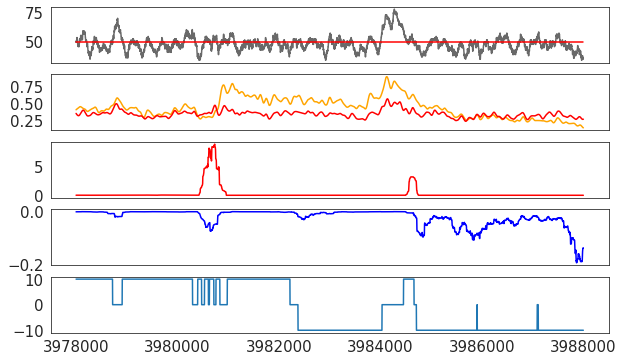

In [38]:
#FigS3G, GapR at tRNA representative example
start=3978000
end=3988000
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),sliding_100[0][start:end],'dimgrey')
axes[0].plot([start, end],[np.mean(sliding_100[0]),np.mean(sliding_100[0])],'red')
#axes[1].plot(np.arange(start, end),chip.wtH[start:end],'black')
axes[1].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[1].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[2].plot(np.arange(start, end),(RNAseq_me['fwd'][start:end]),'red')
axes[3].plot(np.arange(start, end),-(RNAseq_me['rev'][start:end]),'blue')

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)

axes[4].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig S3H

In [70]:
#Uses only one operon in convergent / divergent orientation to prevent double counting
operonLen = 1500
N = 1000
plus = MGoperons[(MGoperons.strand == 0) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]
minus = MGoperons[(MGoperons.strand == 1) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.start >= values.end) & (minus.start <= values.end+1000)])
    if len(x) != 0:
        t.append(x)

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.start) & (plus.start <= values.end+1000)])
    if len(x) != 0:
        t2.append(x)

#redo 5' and 3' with dropping?
minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
plus_new = plus.copy()
for x in t2:
    plus_new.drop(index = x.index,inplace=True)

t-test of start of TUs: Ttest_indResult(statistic=-6.769590713745673, pvalue=1.811717147619292e-11)


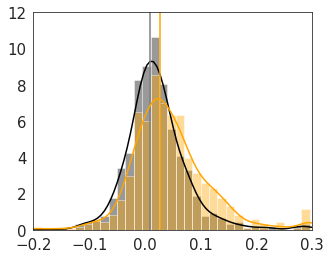

In [62]:
#Calculate GapR-3xFLAG and generate figure
minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
for index, values in plus[1:].iterrows():
    end = int(values.end)
    if end < len(MG1655)-N:
        data_y_end.append(np.sum(chip.high.values[end:end+N])/N-np.sum(chip.high.values[end-N:end])/N)
for index, values in plus_new[1:].iterrows():
    start = int(values.start)
    if start > N:
        data_y_start.append(np.sum(chip.high.values[start-N:start])/N-np.sum(chip.high.values[start:start+N])/N)

data_y_plus_end=data_y_end
data_y_plus_start=data_y_start

data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
for index, values in minus_new.iterrows():
    end = int(values.start)
    if end > N:
        data_y_end.append(np.sum(chip.high.values[end-N:end])/N-np.sum(chip.high.values[end:end+N])/N)
for index, values in minus.iterrows():
    start = int(values.end)
    if start < len(MG1655)-N:
        data_y_start.append(np.sum(chip.high.values[start:start+N])/N-np.sum(chip.high.values[start-N:start])/N)

        data_y_rev_end=data_y_end
data_y_rev_start=data_y_start

data_y_concat_2_end=np.concatenate((data_y_plus_end,data_y_rev_end))
data_y_concat_2_start=np.concatenate((data_y_plus_start,data_y_rev_start))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(-0.20,0.3,0.015)

sns.distplot(np.clip(data_y_concat_2_start,bins[0],bins[-1]),bins=bins, norm_hist=True, color='black')#,fit=norm, kde=False)
kde = stats.gaussian_kde(data_y_concat_2_start)
xs = np.linspace(-0.3, 0.3, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='grey')
sns.distplot(np.clip(data_y_concat_2_end,bins[0],bins[-1]),bins=bins, norm_hist=True,color='orange')#,fit=norm, kde=False)
kde = stats.gaussian_kde(data_y_concat_2_end)
xs = np.linspace(-0.3, 0.3, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
plt.xlim([-0.20,0.3])
plt.ylim([0,12])
print('t-test of start of TUs: '+ str(stats.ttest_ind(data_y_concat_2_start,data_y_concat_2_end)))

### Fig S3I

In [71]:
#Uses only one operon in convergent / divergent orientation to prevent double counting
operonLen = 1500
N = 1000
plus = MGoperons[(MGoperons.strand == 0) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]
minus = MGoperons[(MGoperons.strand == 1) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.start >= values.end) & (minus.start <= values.end+1000)])
    if len(x) != 0:
        t.append(x)

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.start) & (plus.start <= values.end+1000)])
    if len(x) != 0:
        t2.append(x)

#redo 5' and 3' with dropping?
minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
plus_new = plus.copy()
for x in t2:
    plus_new.drop(index = x.index,inplace=True)

t-test of start of TUs: Ttest_indResult(statistic=-7.800714954377853, pvalue=1.1073063943881298e-14)


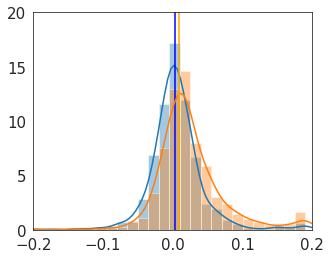

In [64]:
#Calculate transcription-dependent change in GapR-3xFLAG and generate figure
data_y_end, data_y_start = [],[]
for index, values in plus[1:].iterrows():
    end = int(values.end)
    if end < len(MG1655)-N:
        data_y_end.append((np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N))
for index, values in plus_new[1:].iterrows():
    start = int(values.start)
    if start > N:
        data_y_start.append((np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N))


data_y_plus_end=data_y_end
data_y_plus_start=data_y_start

data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
for index, values in minus_new.iterrows():
    end = int(values.start)
    if end > N:
        data_y_end.append((np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N))
for index, values in minus.iterrows():
    start = int(values.end)
    if start < len(MG1655)-N:
        data_y_start.append((np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N))

data_y_rev_end=data_y_end
data_y_rev_start=data_y_start

data_y_concat_2_end=np.concatenate((data_y_plus_end,data_y_rev_end))
data_y_concat_2_start=np.concatenate((data_y_plus_start,data_y_rev_start))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(-0.2,0.2,0.015)

sns.distplot(np.clip(data_y_concat_2_start,bins[0],bins[-1]),bins=bins, norm_hist=True)#,fit=norm, kde=False)
kde = stats.gaussian_kde(data_y_concat_2_start)
xs = np.linspace(-0.3, 0.3, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
sns.distplot(np.clip(data_y_concat_2_end,bins[0],bins[-1]),bins=bins, norm_hist=True)#,fit=norm, kde=False)
kde = stats.gaussian_kde(data_y_concat_2_end)
xs = np.linspace(-0.3, 0.3, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
plt.xlim([-0.20,0.20])
plt.ylim([0,20])
print('t-test of start of TUs: '+ str(stats.ttest_ind(data_y_concat_2_start,data_y_concat_2_end)))

### Fig S3J

In [72]:
#Uses only one operon in convergent / divergent orientation to prevent double counting
operonLen = 1500
N = 1000
plus = MGoperons[(MGoperons.strand == 0) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]
minus = MGoperons[(MGoperons.strand == 1) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.start >= values.end) & (minus.start <= values.end+1000)])
    if len(x) != 0:
        t.append(x)

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.start) & (plus.start <= values.end+1000)])
    if len(x) != 0:
        t2.append(x)

#redo 5' and 3' with dropping?
minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
plus_new = plus.copy()
for x in t2:
    plus_new.drop(index = x.index,inplace=True)

t-test of end of TUs: 3.284 Ttest_indResult(statistic=7.13172645489698, pvalue=2.21972282975999e-12)
t-test of end of TUs: 25.7 Ttest_indResult(statistic=9.160098861398772, pvalue=1.3493083348342838e-18)
t-test of end of TUs: 65 Ttest_indResult(statistic=9.846722584989037, pvalue=1.7333231059494166e-20)


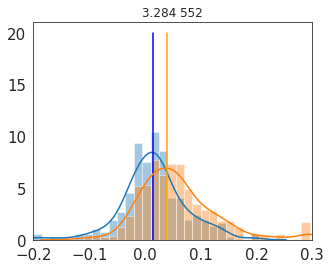

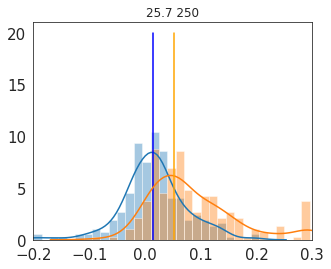

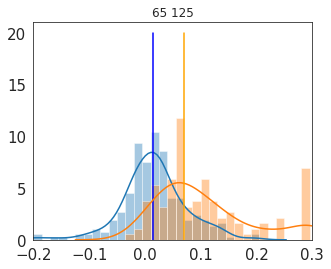

In [65]:
#GapR-3xFLAG enrichment at different transcriptional cutoffs, 3pr end
operonLen = 1500
N = 1000
thrsh_x_2 = 3.284

rand_prob_3pr = {}
for thrsh_x in [3.284,25.7,65]:
    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in plus[1:].iterrows():
        if values.newRPK > thrsh_x:
            end = int(values.end)
            if end < len(MG1655)-N:
                data_y_end.append((np.sum(chip.high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N))
                
        elif values.newRPK < thrsh_x_2:
            end = int(values.end)
            if end < len(MG1655)-N:
                data_y2_end.append((np.sum(chip.high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N))
    data_y_plus_end=data_y_end
    data_y_plus_end_2=data_y2_end
    data_y_plus_start=data_y_start
    data_y_plus_start_2=data_y2_start


    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in minus_new.iterrows():
        if values.newRPK > thrsh_x:
            end = int(values.start)
            if end > N:
                data_y_end.append((np.sum(chip.high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N))
                
        elif values.newRPK < thrsh_x_2:
            end = int(values.start)
            if end > N:
                data_y2_end.append((np.sum(chip.high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N))
                
    data_y_rev_end=data_y_end
    data_y_rev_end_2=data_y2_end
    data_y_rev_start=data_y_start
    data_y_rev_start_2=data_y2_start

    data_y_concat_end=np.concatenate((data_y_plus_end,data_y_rev_end))
    data_y_concat_2_end=np.concatenate((data_y_plus_end_2,data_y_rev_end_2))
    data_y_concat_start=np.concatenate((data_y_plus_start,data_y_rev_start))
    data_y_concat_2_start=np.concatenate((data_y_plus_start_2,data_y_rev_start_2))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_2_end,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_2_end)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
    
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_end,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_end)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
    
    plt.xlim([-0.2,0.3])

    axes.set_title(str(thrsh_x)+' '+str(len(data_y_concat_end)))

    print('t-test of end of TUs: '+ str(thrsh_x) + ' '+ str(stats.ttest_ind(data_y_concat_end,data_y_concat_2_end)))

t-test of end of TUs: 3.284 Ttest_indResult(statistic=-0.3495821518521273, pvalue=0.7267459486877286)
t-test of end of TUs: 25.7 Ttest_indResult(statistic=0.48842974941801304, pvalue=0.6254609043590452)
t-test of end of TUs: 65 Ttest_indResult(statistic=2.250733710887248, pvalue=0.024990573873274823)


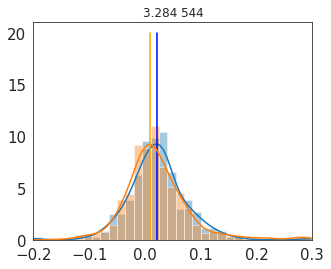

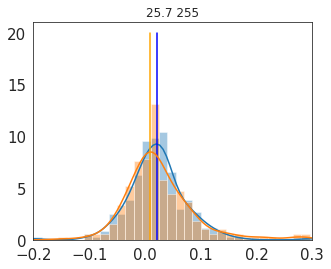

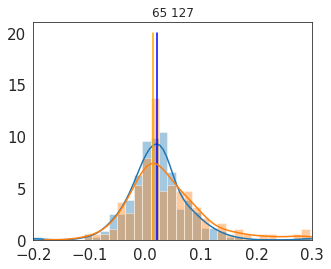

In [66]:
#GapR-3xFLAG enrichment at different transcriptional cutoffs, 3pr end
thrsh_x_2 = 3.284

rand_prob_3pr = {}
for thrsh_x in [3.284,25.7,65]:
    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in plus_new.iterrows():
        if values.newRPK > thrsh_x:
            start = int(values.start)
            if start > N:
                data_y_start.append((np.sum(chip.high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N))
        elif values.newRPK < thrsh_x_2:
            start = int(values.start)
            if start > N:
                data_y2_start.append((np.sum(chip.high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N))
    data_y_plus_end=data_y_end
    data_y_plus_end_2=data_y2_end
    data_y_plus_start=data_y_start
    data_y_plus_start_2=data_y2_start


    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in minus.iterrows():
        if values.newRPK > thrsh_x:
            start = int(values.end)
            if start < len(MG1655)-N:
                data_y_start.append((np.sum(chip.high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N))
        elif values.newRPK < thrsh_x_2:
            start = int(values.end)
            if start < len(MG1655)-N:
                data_y2_start.append((np.sum(chip.high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N))
                
    data_y_rev_end=data_y_end
    data_y_rev_end_2=data_y2_end
    data_y_rev_start=data_y_start
    data_y_rev_start_2=data_y2_start

    data_y_concat_end=np.concatenate((data_y_plus_end,data_y_rev_end))
    data_y_concat_2_end=np.concatenate((data_y_plus_end_2,data_y_rev_end_2))
    data_y_concat_start=np.concatenate((data_y_plus_start,data_y_rev_start))
    data_y_concat_2_start=np.concatenate((data_y_plus_start_2,data_y_rev_start_2))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_2_start,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_2_start)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
    
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_start,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_start)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
    
    plt.xlim([-0.2,0.3])

    axes.set_title(str(thrsh_x)+' '+str(len(data_y_concat_start)))

    print('t-test of end of TUs: '+ str(thrsh_x) + ' '+ str(stats.ttest_ind(data_y_concat_start,data_y_concat_2_start)))

### Fig S3K

In [67]:
#Find highest GapR-3xFLAG bound regions
def enrichedRegions(chip_data, cutoff):
    x = chip_data[chip_data > cutoff]
    out = []
    z = x.index[0]
    start = x.index[0]
    for i in range(1,len(x.index)):
        if x.index[i] == z+1:
            z = x.index[i]
        else:
            end = z
            out.append([start,end])
            z = x.index[i]
            start = x.index[i]
    out.append([start,z])
    return out 

#for my ecoli data, just looking at rif change in GapR binding.
out_high = enrichedRegions(chip.high-chip.Rif_high,.11849042) #this is the 5% of positions with greatest GapR enrichment
print(len(out_high))

chip_diff = chip.high-chip.Rif_high

#expand GapR ChIP peaks
out = []
regions = out_high
m = np.mean(chip_diff)
s = np.std(chip_diff)
for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-15000:z[1]+15000]
    c_diff = c[c>(m+1/3*s)]#I'm calling a "peak" anything more than mean + 1/3 std
    j = z[1]
    while j < z[1]+15000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+15000
    j = z[0]
    while j > z[0]-15000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-15000
    if start > end:
        print('problem!')
    out.append(tuple([start,end]))
    
regions = sorted(list(set(out)))
out = []

i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 150: #merge regions smaller than fragment size
        end = regions[i][1]
        i += 1
    else:
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
print(len(out))
GapR_peaks = out

#calculate lengths for each of the GapR peaks:
gapR_length = []
for i in out:
    m = i[1]-i[0] 
    gapR_length.append(i[1]-i[0])

915
223


2520.843049327354 1773.0 2131.4342667937126 223


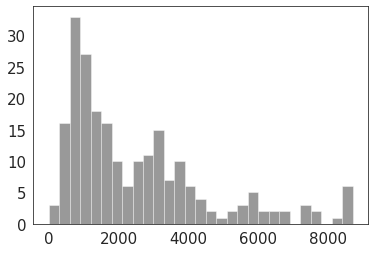

In [68]:
#histogram of size of GapR peaks
bins = np.arange(0,9000,300)
sns.distplot(np.clip(gapR_length,bins[0],bins[-1]),bins=bins,kde=False,norm_hist=False,color='black')
print(np.mean(gapR_length), np.median(gapR_length), np.std(gapR_length),len(gapR_length))